In [18]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np

In [19]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

In [20]:
#fig = plt.figure(figsize=(10,5))
#ax = plt.subplot(111)
#times, rv = true_state.get_rv_plotting(tmax=10.)
#ax.plot(times, rv)
#ax.plot(obs.t, obs.rv, ".")

In [21]:
varState = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0., "l":1.4}], ignore_vars=["a","m"])

varState.get_chi2(obs)

100.98857205487279

In [22]:
Delta = 1e-4
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0., "l":1.4}], ignore_vars=["a","m"])
chi2 = s.get_chi2(obs)
fd_d = np.zeros(s.Nvars)
fd_dd = np.zeros((s.Nvars,s.Nvars))
for i in range(s.Nvars):
    shift = np.zeros(s.Nvars)
    shift[i] = Delta
    s.shift_params(shift);
    chi2p = s.get_chi2(obs)
    s.shift_params(-shift);
    fd_d[i] = (chi2p-chi2)/Delta
    for j in range(s.Nvars):
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2pp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2mp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2pm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2mm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        fd_dd[i][j] = (chi2pp-chi2mp-chi2pm+chi2mm)/(4.*Delta**2)

chi2, v_d, v_dd = s.get_chi2_d_dd(obs)

print("First order:")
print(fd_d)
print(v_d)
print("\nSecond order:")
print(fd_dd)
print(v_dd)

First order:
[  56.51570708  -25.61966507  106.92514277]
[  56.51546141  -25.61773375  106.92638615]

Second order:
[[   4.92592385  -94.02433072  -58.70103301]
 [ -94.02433072  -38.62532019 -148.45232172]
 [ -58.70103301 -148.45232172  -24.86402444]]
[[   4.9259464   -94.02432271  -58.70104606]
 [ -94.02432271  -38.62531858 -148.45231724]
 [ -58.70104606 -148.45231724  -24.86401257]]


In [23]:
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0., "l":1.4}], ignore_vars=["a","m"])
mh = mcmc.Mh(s,obs)
mh.scales = 5e-2*np.ones(s.Nvars)
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
tries = 0
for i in range(Niter):
    tries += mh.step_force()
    chain[i] = mh.state.get_params()
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 66.27%


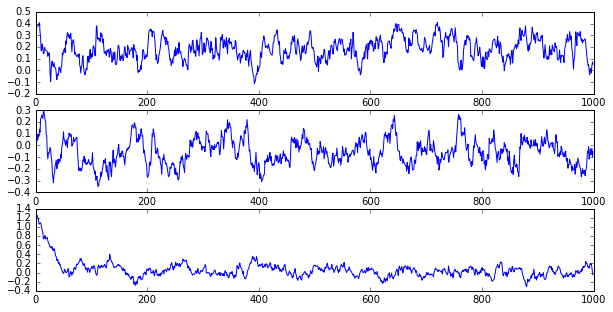

In [24]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars,1,1+i)
    ax.plot(chain[:,i])

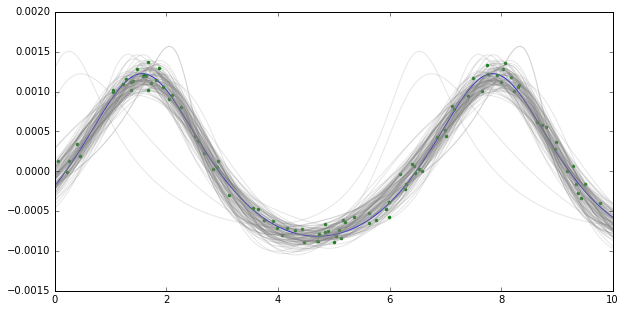

In [25]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
times, rv = true_state.get_rv_plotting(tmax=10.)
ax.plot(times, rv)
ax.plot(obs.t, obs.rv, ".")
for c in np.random.choice(Niter,100):
    state = mh.state.deepcopy()
    state.set_params(chain[c])
    times, rv = state.get_rv_plotting(tmax=10.)
    ax.plot(times, rv, alpha=0.2, color="gray")